### To reproduce Figure 4 results (Cora dataset):

We will reproduce the results for the Cora dataset by default, but you can choose any dataset you want by following the instructions below.

1. Open `scripts/run_figure4.sh`
2. Modify as needed:
   - `datasets` (default=Cora)
   - `experiment_name` (Name for the experiment, will be used as directory name for logs)
   - `fraction_data_gcn` (Controls the feature ratio, 1 - feature ratio owned by the adversary)
   - Modify the parallel parameter (-j) to adjust the number of concurrent jobs based on your system's capabilities


3. Make the script executable:
   ```
   chmod +x scripts/run_figure4.sh
   ```

4. Run the script:
   ```
   bash scripts/run_figure4.sh
   ```

Results will be logged to wandb and saved in the `logs/{experiment_name}` directory.

### Note: To reproduce results for other datasets in Figure 4:
- Modify the `datasets` array in the script (e.g., datasets=('CiteSeer') for CiteSeer dataset)
- Change the `experiment_name` accordingly (e.g., "Figure 4 results CiteSeer")

For example, to reproduce results for CiteSeer:
1. In `scripts/run_figure4.sh`, change:
   ```
   datasets=('CiteSeer')
   experiment_name="Figure 4 results CiteSeer"
   ```
2. Run the script as described above

Note: We used GCN architecture for all datasets in Figure 4, so keep architectures=('gcn')

### Parsing the results

After running the script, the logs of the experiments are stored in the directory `logs/Figure 4 results Cora`.
The code below parses these results to compute the maximum AUC achieved during training for the Gradient, Inter-Reps, and Feature-based attacks across multiple seeds and different feature ratios.


The code also renames some attack methods to match the names used in the paper:
- 'gradients' is used for the Gradient-based LIA
- 'forward_values' is renamed to 'Inter-Reps'
- 'features' is used for the Feature-based LIA

Don't forget to change the experiment name in the code in the next cell to parse the correct logs of the experiment for the new dataset if you're reproducing results for a different dataset.

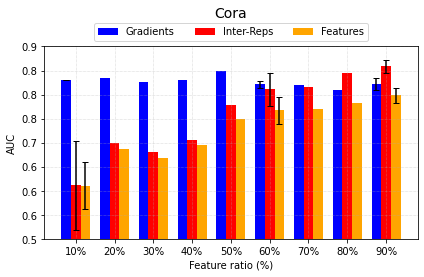

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

def parse_results(experiment_dir):
    results = []
    for subdir in os.listdir(experiment_dir):
        csv_path = os.path.join(experiment_dir, subdir, 'attack_results.csv')
        config_path = os.path.join(experiment_dir, subdir, 'config.json')
        
        if os.path.exists(csv_path) and os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
                fraction_data_gcn = config.get('fraction_data_gcn', None)
            
            if fraction_data_gcn is None:
                continue
            
            df = pd.read_csv(csv_path)
            auc_df = df[df['metric'].str.startswith('AUC-')].copy()
            auc_df['value'] = auc_df['value'].apply(safe_float)
            
            for attack in ['gradients', 'forward_values', 'features']:
                attack_results = auc_df[auc_df['metric'] == f'AUC-{attack}']
                if not attack_results.empty:
                    max_auc = attack_results['value'].max()
                    attack_name = 'Inter-Reps' if attack == 'forward_values' else attack.capitalize()
                    results.append({
                        'attack': attack_name,
                        'max_auc': max_auc,
                        'seed': subdir,
                        'fraction_data_gcn': fraction_data_gcn
                    })
    
    return pd.DataFrame(results)

experiment_dir = '../logs/Figure 4 results Cora'
results_df = parse_results(experiment_dir)
grouped_results = results_df.groupby(['attack', 'fraction_data_gcn'])['max_auc'].agg(['mean', 'std']).reset_index()

def custom_formatter(x, _):
    if int(x) == x:
        return str(int(x))
    else:
        return str(round(x, 1))

fig, ax = plt.subplots(figsize=(6, 4))
width = 0.25
feature_ratios = (1 - grouped_results['fraction_data_gcn'].unique()) * 100  # Use fraction_data_gcn directly
x = np.arange(len(feature_ratios))

colors = {'Gradients': 'blue', 'Inter-Reps': 'red', 'Features': 'orange'}
for i, attack in enumerate(['Gradients', 'Inter-Reps', 'Features']):
    data = grouped_results[grouped_results['attack'] == attack].sort_values('fraction_data_gcn', ascending=False)
    ax.bar(x + i*width, data['mean'], width, yerr=data['std'], 
           label=attack, color=colors[attack], capsize=3)

ax.set_xlabel('Feature ratio (%)')
ax.set_ylabel('AUC')
dataset = experiment_dir.split()[-1]  # Get the last word of experiment_dir
ax.set_title(dataset, fontsize=14, y=1.12)
ax.set_xticks(x + width)
ax.set_xticklabels([f'{ratio:.0f}%' for ratio in sorted(feature_ratios)])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

ax.set_ylim(0.5, 0.9)
ax.grid(which='both', linestyle=':', linewidth=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.tight_layout()
# plt.savefig('feature_ratio_comparison_cora.pdf', dpi=300, bbox_inches='tight')
plt.show()



In [2]:
grouped_results

,attack,fraction_data_gcn,mean,std
0,Features,0.1,0.798077,0.016212
1,Features,0.2,0.782357,NaN
2,Features,0.3,0.769736,NaN
3,Features,0.4,0.767003,0.027742
4,Features,0.5,0.749622,NaN
5,Features,0.6,0.695455,NaN
6,Features,0.7,0.668446,NaN
7,Features,0.8,0.686807,NaN
8,Features,0.9,0.610740,0.049112
9,Gradients,0.1,0.822097,0.011897
